In [41]:
# 1. IMPORTS BLOCK (updated)
import numpy as np
from numpy import interp
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier,
                             ExtraTreesClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier)

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Critical fix

# Pipelines
from sklearn.pipeline import Pipeline

In [43]:
def load_data(use_ucirepo=True):
    """Load data from either UCI repo or local CSV"""
    if use_ucirepo:
        from ucimlrepo import fetch_ucirepo
        data = fetch_ucirepo(id=144)
        X = data.data.features
        y = data.data.targets.replace({1:0, 2:1}).values.ravel()
    else:
        data = pd.read_csv(
            '/path/to/local.csv',
            delimiter=';', 
            skiprows=1,
            names=['existingchecking', 'duration', ...]  # full column names
        )
        y = data['classification'].replace({1:0, 2:1}).values.ravel()
        X = data.drop('classification', axis=1)
    
    return X, y

In [45]:
def preprocess_data(X, y, oversample=True):
    """Preprocess data with optional oversampling"""
    # Feature type identification
    cat_features = X.select_dtypes(include=['object']).columns
    num_features = X.select_dtypes(include=['int64','float64']).columns
    
    # Preprocessor pipeline
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Pipeline with optional SMOTE
    if oversample:
        pipe = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('model', None)
        ])
    else:
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', None)
        ])
    
    return pipe, X_train, X_test, y_train, y_test, num_features, cat_features

In [47]:
def get_models():
    """Return dictionary of configured models"""
    return {
        'RandomForest': RandomForestClassifier(
            class_weight={0:1, 1:5}, random_state=42),
        
        'BaggedRF': BaggingClassifier(
            estimator=RandomForestClassifier(
                class_weight={0:1, 1:5}, max_depth=5, random_state=42),
            n_estimators=10, random_state=42),
        
        'ExtraTrees': ExtraTreesClassifier(
            class_weight={0:1, 1:5}, random_state=42),
        
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=100, random_state=42),
        
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }

In [49]:
def evaluate_model(model, X_test, y_test):
    """Generate evaluation metrics and plots"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Classification report
    print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))
    
    # Confusion matrix and cost
    cm = confusion_matrix(y_test, y_pred)
    cost = cm[0,1]*1 + cm[1,0]*5
    print(f"Confusion Matrix:\n{cm}")
    print(f"Total Cost: {cost}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return {'cm': cm, 'cost': cost, 'roc_auc': roc_auc}

In [51]:
def show_feature_importance(model, preprocessor, num_features, cat_features):
    """Display top 5 most important features"""
    # Get feature names
    feature_names = num_features.tolist() + \
                   list(preprocessor.named_transformers_['cat']
                       .get_feature_names_out(cat_features))
    
    # Get the actual model from the pipeline
    model_step = model.named_steps['model']
    
    # Extract importances based on model type
    if isinstance(model_step, BaggingClassifier):
        importances = np.mean([est.feature_importances_ 
                             for est in model_step.estimators_], axis=0)
    elif hasattr(model_step, 'feature_importances_'):
        importances = model_step.feature_importances_
    else:
        print("Feature importance not available for this model type")
        return
    
    # Display top features
    importance_df = pd.Series(importances, index=feature_names)
    print(importance_df.sort_values(ascending=False).head(5))


=== RandomForest ===
              precision    recall  f1-score   support

        Good       0.79      0.92      0.85       210
         Bad       0.70      0.44      0.54        90

    accuracy                           0.78       300
   macro avg       0.75      0.68      0.70       300
weighted avg       0.77      0.78      0.76       300

Confusion Matrix:
[[193  17]
 [ 50  40]]
Total Cost: 267


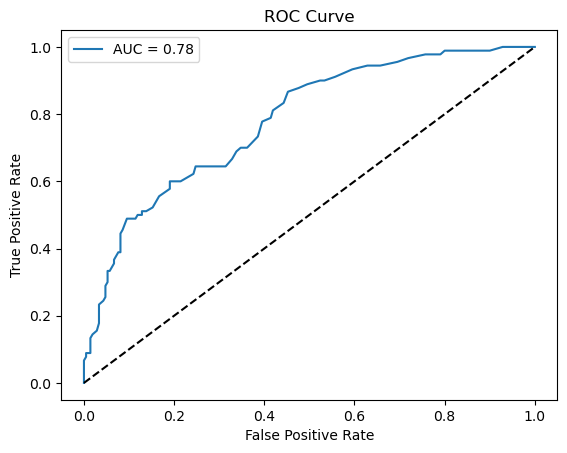


=== BaggedRF ===
              precision    recall  f1-score   support

        Good       0.92      0.37      0.53       210
         Bad       0.39      0.92      0.54        90

    accuracy                           0.54       300
   macro avg       0.65      0.65      0.54       300
weighted avg       0.76      0.54      0.53       300

Confusion Matrix:
[[ 78 132]
 [  7  83]]
Total Cost: 167


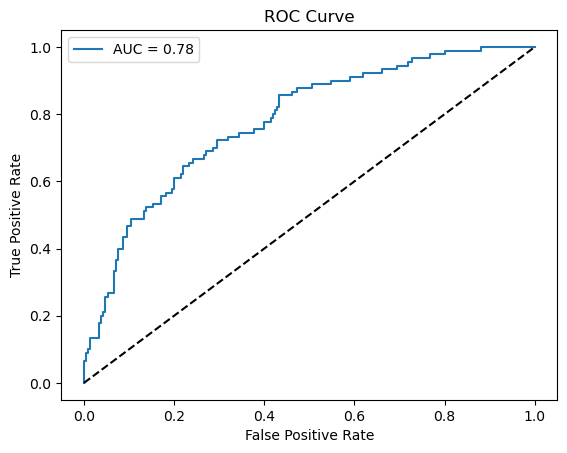


=== ExtraTrees ===
              precision    recall  f1-score   support

        Good       0.79      0.89      0.83       210
         Bad       0.63      0.43      0.51        90

    accuracy                           0.75       300
   macro avg       0.71      0.66      0.67       300
weighted avg       0.74      0.75      0.74       300

Confusion Matrix:
[[187  23]
 [ 51  39]]
Total Cost: 278


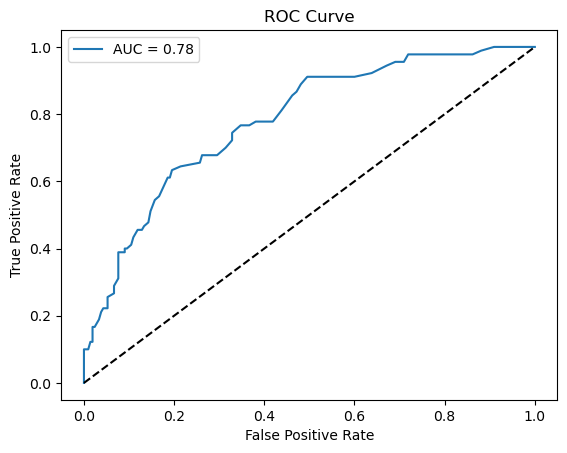


=== GradientBoosting ===
              precision    recall  f1-score   support

        Good       0.81      0.84      0.82       210
         Bad       0.59      0.53      0.56        90

    accuracy                           0.75       300
   macro avg       0.70      0.69      0.69       300
weighted avg       0.74      0.75      0.74       300

Confusion Matrix:
[[176  34]
 [ 42  48]]
Total Cost: 244


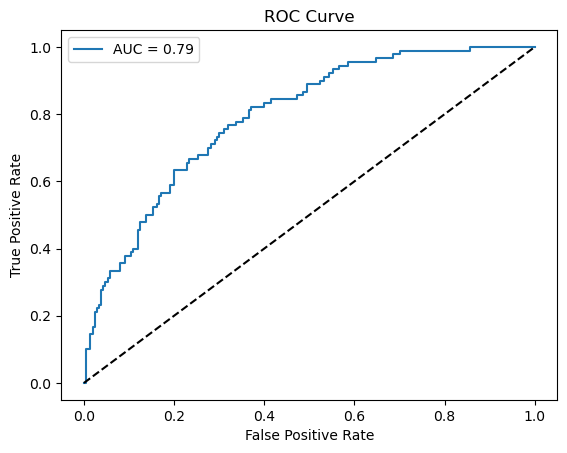


=== AdaBoost ===


D:\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

        Good       0.82      0.80      0.81       210
         Bad       0.55      0.58      0.57        90

    accuracy                           0.73       300
   macro avg       0.68      0.69      0.69       300
weighted avg       0.74      0.73      0.73       300

Confusion Matrix:
[[168  42]
 [ 38  52]]
Total Cost: 232


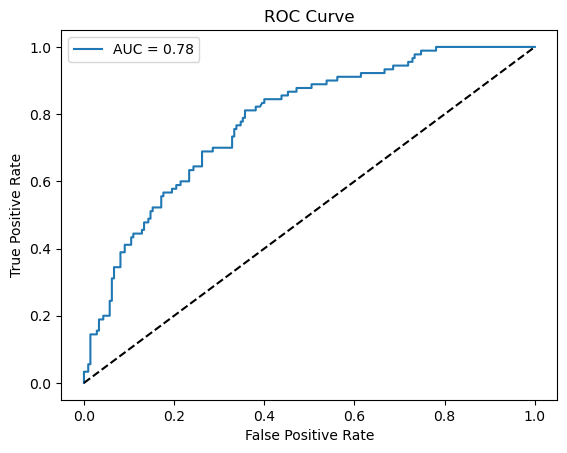


Best Model: BaggedRF
Attribute1_A14    0.147252
Attribute2        0.076788
Attribute6_A61    0.062024
Attribute1_A11    0.049066
Attribute13       0.044079
dtype: float64


In [53]:
def main():
    # Load data
    X, y = load_data()
    
    # Preprocess
    pipe, X_train, X_test, y_train, y_test, num_features, cat_features = preprocess_data(X, y)
    
    # Get models
    models = get_models()
    
    # Train and evaluate
    results = {}
    for name, model in models.items():
        print(f"\n=== {name} ===")
        current_pipe = pipe.set_params(model=model)
        current_pipe.fit(X_train, y_train)
        results[name] = evaluate_model(current_pipe, X_test, y_test)
    
    # Select best model
    best_name = min(results.items(), key=lambda x: x[1]['cost'])[0]
    print(f"\nBest Model: {best_name}")
    
    # Feature importance
    show_feature_importance(pipe.set_params(model=models[best_name]),
                          pipe.named_steps['preprocessor'],
                          num_features, cat_features)

if __name__ == "__main__":
    main()